---
title-block-banner: true
title: DCGAN face tutorial
subtitle: Generating Adversarial Example 
description: 실제 유명인들의 사진들로 적대적 생성 신경망(GAN)을 학습시켜, 새로운 유명인의 사진을 만든다.
categories:
    - PyTorch
    - computer vision
    - tutorial
date: 2024/03/09

toc: false      # 코드 영역때문에 페이지가 답답함
reference-location: document    # callout에서 사용하는 각주가 너무 많다.
---

## GAN?

1. 학습 데이터들의 *분포*를 학습해
2. 새로운 데이터를 *생성*

- 생성자와 구분자로 구별되는 두 모델을 가지고 있다.
    - 생성자: 실제 이미지와 유사한 정교한 이미지 생성
    - 구분자: 실제 이미지인지 생성자의 이미지인지 판별
- 생성자와 구분자의 상호작용을 통해 실제와 같은 이미지를 만들어낸다.
- 구분자가 생성자의 이미지 중 50%를 제대로 판별할 때 *균형상태*에 도달했다고 말한다.

> DGGAN: GAN에서 파생된 모델로 생성자와 구분자에서 '합성곱 신경망(Convolution)'과 '전치 합성곱 신경망(Convolution-transpose)'를 사용했다

In [1]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn 
import torch.nn.parallel
import torch.backends.mps as mps 

import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


In [2]:
# seed
manualSeed = 42
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


### Config

In [3]:
# dataset dir root path
dataroot = "./data/celeba" 

# dataloader에서 사용할 thread 수
workers = 2

batch_size = 256

# 이미지의 크기; 모든 이미지 변환하여 크기 통일함
image_size = 64

# number channel; RGB이미지이므로 3
nc = 3

# latent vector size = 생성자의 입력값 크기
nz = 100

# 생성자를 통과하는 특징 데이터의 채널 크기
ngf = 64

# 구분자를 통과하는 특징 데이터의 채널 크기
ndf = 64

num_epochs = 1

lr = 0.0002

# adam optimizer의 beta1 하이퍼파라미터
beta1 = 0.5

# 사용가능한 gpu 번호; cpu = 0
ngpu = 0

### Data

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)

# 데이터가 너무 커서 샘플로 몇개만 뽑음
sample_size = batch_size*1000
dataset, _dataset = torch.utils.data.random_split(dataset, lengths=[sample_size, len(dataset)-sample_size])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)

# device
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

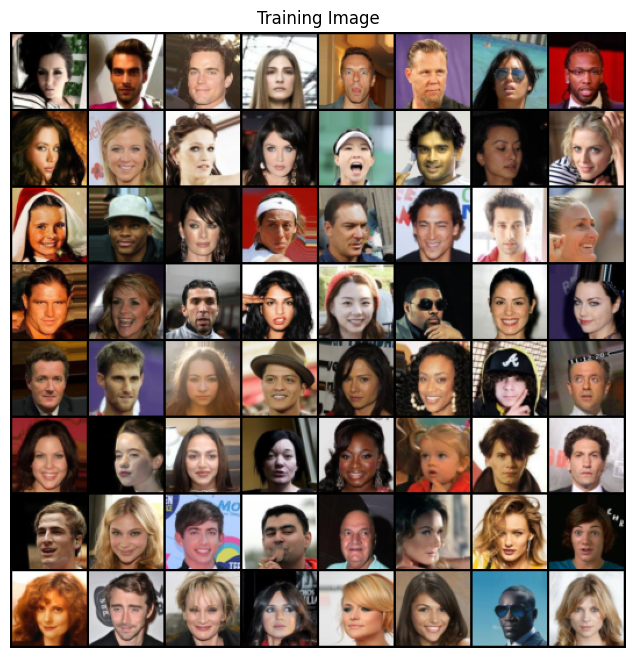

In [5]:
# real batch check
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Image")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### 구현

#### 가중치 초기화

- 평균 0, 분산 0.02인 정규분포
    - `mean = 0` `stdev=0.02`
    - 구분자와 생성자 모두 *무작위 초기화* 진행

In [6]:
# 매개변수로 '모델'을 받아 합성곱, 전치합성곱, 배치정규화 계층을 초기화

def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('ConV') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

#### 생성자

- 잠재공간 $z$를 데이터공간, 즉 이미지로 변환하는 과정을 거친다 ($3 \times 64 \times 64$)
- stride 2를 가진 전치 합성곱 계층을 이어서 구성
    - 각 전치 합성곱 계층 하나당 아래 두개 레이어를 쌍으로 묶어 사용함
        - 2차 배치 정규화 계층
        - relu 활성화 함수
- 마지막 출력 계층에서는 `tanh` 함수를 사용하는데 이는 *출력값을 $[-1, 1]$ 사이로 조정하기 위함* 이다.
- 배치 정규화 계층이 중요한데, 이 계층이 경사 하강법의 흐름에 중요한 역할을 했다고 함 (논문 원문 참조)

In [7]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # ngf: 생성자를 통과하는 특징 데이터의 채널 크기
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0 ),     # 왜 ngf를 8배 하나?
            nn.BatchNorm2d( ngf * 8 ),
            nn.ReLU(True),
            
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d( ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # 위의 계층을 통과한 데이터의 크기. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # 위의 계층을 통과한 데이터의 크기. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # 위의 계층을 통과한 데이터의 크기. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [8]:
netG = Generator(ngpu).to(device)

# 모든 가중치의 평균을 0, 분산을 0.02로 초기화
netG.apply(weights_init)

# 모델 구조 확인
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

### 구분자

- 입력: $3 \times 64 \times 64$
- Conv2d, BatchNorm2d, LeakyReLU로 데이터를 가공
    - stride를 합성곱 계층에서 적용하는데 논문에서는 스스로 pooling을 학습하기 때문에 pooling 계층을 넣지 않아도 효과가 좋았다고 한다.
- 마지막 계층 Sigmoid로 확률값 반환

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # 입력 데이터의 크기는 ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 위의 계층을 통과한 데이터의 크기. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 위의 계층을 통과한 데이터의 크기. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [10]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

### 최적화


- 손실함수로 `BCELoss`^[Binary Cross Entropy loss] 사용
    
    $\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}$
    
    - 여기서 조정해야하는 $log(D(x))$ 와 $log(1 - D(G(Z)))$ 를 확인할 수 있다.

> 목표: $y$를 이용하여 손실함수를 최대화하는 방법 찾기

In [11]:
criterion = nn.BCELoss()

# 입력, 잠재공간 벡터 생성
# device = device 아니고 device만 넣으면 에러
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# 참 거짓의 라벨
real_label = 1
fake_label = 0 

# optimizer 생성
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### 학습

#### 구분자의 학습

> 손실함수를 어떻게 최대화 할 것인가?

1. 실제 데이터만 가져와 미니배치를 만든 후 훈련한다: $D$ (학습)
    1. 1의 결과로 얻은 $log(D(x))$ 의 손실값을 계산한다. (수식 계산)
    2. 역전파 과정에서의 변화도를 계산한다.
    - 이들 변화값은 축적(accumulate)시켜야 한다.
    - 이후 최적화 함수를 사용한다.
2. $log(D(G(z)))$ 를 최대화 하는 방식으로 학습^[$log(1 - D(G(z)))$ 최소화는 원문 논문에서 효율적이지 못하다고 언급함]
    - 진짜 이미지들에서 `G`의 손실값을 구하고 가짜이미지에서도 같은 방식을 적용한다.
    - 이 과정에서 `BCELoss`의 일부인 $log(x)$를 일부 사용할 수 있다.

> 실제값과 거짓값의 학습에서 나타나는 차이점을 통해 손실함수를 분리한다.

튜토리얼에서는 다음과 같이 사용한다.

-  **Loss_D** - 진짜 데이터와 가짜 데이터들 모두에서 구해진 손실값. ($log(D(x)) + log(1 - D(G(z)))$).
-  **Loss_G** - 생성자의 손실값. $log(D(G(z)))$
-  **D(x)** - 구분자가 데이터를 판별한 확률값입니다. 처음에는 1에 가까운 값이다가,
   G가 학습할수록 0.5값에 수렴하게 됩니다.
-  **D(G(z))** - 가짜데이터들에 대한 구분자의 출력값입니다. 처음에는 0에 가까운 값이다가,
   G가 학습할수록 0.5에 수렴하게 됩니다


In [12]:
# 손실값들을 저장

img_list, G_losses, D_losses = [], [], []
iters = 0

# `배치` 반복
def batch_loop(dataloader, netD, netG, criterion, epoch):
    for i, data in enumerate(dataloader, 0):
        ##################################
        # (1) D 신경망 업데이트
        # 실제 데이터로 학습
        # 전체 손실함수 값을 최대화
        ##################################

        # --- 실제 데이터 학습 --- #
        netD.zero_grad()

        # 배치의 사이즈나 사용할 디바이스에 맞게 조정하는 이유? 
        # >> 효율성?
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label,
                            dtype=torch.float, device=device)
        
        # 실제 데이터 투입
        output = netD(real_cpu).view(-1)
        # 손실값
        errD_real = criterion(output, label)
        # print("errD_real: ", errD_real)
        # 역전파 하며 변화도 계산
        errD_real.backward()
        D_x = output.mean().item()
        # print("D_x: ", D_x)
        

        # --- 가짜 데이터 학습 --- #
        # 생성자에 사용할 잠재공간 벡터
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # 가짜 이미지 생성
        fake = netG(noise)
        # fill_ ?
        label.fill_(fake_label)
        
        # D를 이용해 데이터 진위여부 판별
        output = netD(fake.detach()).view(-1)
        # D의 손실값 계산
        errD_fake = criterion(output, label)
        # 가짜 이미지의 변화도를 계산한 후 변화도에 더한다 (accumulate)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 손실값들을 모두 더한다.
        # errD는 학습 상태를 리포팅 할 때 사용한다! > 임의로 생성한 결과니
        errD = errD_real + errD_fake 

        # D업데이트
        optimizerD.step()
        # print("errD: ", errD)


        ##################################
        # (1) G 신경망 업데이트
        # 실제 데이터를 생성
        # log(D(G(z))) 값을 최대화
        ##################################
        netG.zero_grad()
        label.fill_(real_label)     # 생성자의 손실값을 위해
        # D를 제대로 업데이트했으므로 다시 가짜데이터 투입
        output = netD(fake).view(-1)
        # G의 손실값 계산
        errG = criterion(output, label)
        # G의 변화도 계산
        errG.backward()
        D_G_z2 = output.mean().item()
        # G 업데이트
        optimizerG.step()

        # ---------------------------------
        # 훈련 상태를 출력합니다
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # 이후 그래프를 그리기 위해 손실값들을 저장해둡니다
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # fixed_noise를 통과시킨 G의 출력값을 저장해둡니다
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))


In [13]:
#| output: false
# print("Starting Training Loop...")
# for epoch in range(num_epochs):
#     batch_loop(dataloader, netD, netG, criterion, epoch)

#     iters += 1

'''
Starting Training Loop...
[0/1][0/792]	Loss_D: 1.3083	Loss_G: 3.2819	D(x): 0.5943	D(G(z)): 0.5336 / 0.0397
[0/1][50/792]	Loss_D: 0.2891	Loss_G: 15.2257	D(x): 0.8146	D(G(z)): 0.0000 / 0.0000
[0/1][100/792]	Loss_D: 0.2566	Loss_G: 4.2529	D(x): 0.8360	D(G(z)): 0.0341 / 0.0382
[0/1][150/792]	Loss_D: 1.1949	Loss_G: 1.6857	D(x): 0.3761	D(G(z)): 0.0447 / 0.2113
[0/1][200/792]	Loss_D: 0.9831	Loss_G: 2.3191	D(x): 0.4773	D(G(z)): 0.0473 / 0.1316
[0/1][250/792]	Loss_D: 0.9653	Loss_G: 4.5867	D(x): 0.8587	D(G(z)): 0.5122 / 0.0142
[0/1][300/792]	Loss_D: 0.7742	Loss_G: 2.0908	D(x): 0.5511	D(G(z)): 0.0705 / 0.1749
[0/1][350/792]	Loss_D: 0.7144	Loss_G: 5.1598	D(x): 0.8541	D(G(z)): 0.3957 / 0.0082
[0/1][400/792]	Loss_D: 1.8883	Loss_G: 1.6982	D(x): 0.2203	D(G(z)): 0.0174 / 0.2421
[0/1][450/792]	Loss_D: 0.7316	Loss_G: 5.0640	D(x): 0.8330	D(G(z)): 0.3798 / 0.0097
[0/1][500/792]	Loss_D: 0.4904	Loss_G: 3.8918	D(x): 0.8738	D(G(z)): 0.2750 / 0.0271
[0/1][550/792]	Loss_D: 0.3976	Loss_G: 3.4012	D(x): 0.7631	D(G(z)): 0.0879 / 0.0493
[0/1][600/792]	Loss_D: 1.3403	Loss_G: 7.2067	D(x): 0.9398	D(G(z)): 0.6828 / 0.0012
[0/1][650/792]	Loss_D: 0.5217	Loss_G: 3.1440	D(x): 0.8256	D(G(z)): 0.2559 / 0.0536
[0/1][700/792]	Loss_D: 0.3997	Loss_G: 3.3902	D(x): 0.8364	D(G(z)): 0.1774 / 0.0445
[0/1][750/792]	Loss_D: 0.4414	Loss_G: 3.4481	D(x): 0.8536	D(G(z)): 0.2275 / 0.0386
'''

Starting Training Loop...
[0/1][0/792]	Loss_D: 1.3083	Loss_G: 3.2819	D(x): 0.5943	D(G(z)): 0.5336 / 0.0397
[0/1][50/792]	Loss_D: 0.2891	Loss_G: 15.2257	D(x): 0.8146	D(G(z)): 0.0000 / 0.0000
[0/1][100/792]	Loss_D: 0.2566	Loss_G: 4.2529	D(x): 0.8360	D(G(z)): 0.0341 / 0.0382
[0/1][150/792]	Loss_D: 1.1949	Loss_G: 1.6857	D(x): 0.3761	D(G(z)): 0.0447 / 0.2113
[0/1][200/792]	Loss_D: 0.9831	Loss_G: 2.3191	D(x): 0.4773	D(G(z)): 0.0473 / 0.1316
[0/1][250/792]	Loss_D: 0.9653	Loss_G: 4.5867	D(x): 0.8587	D(G(z)): 0.5122 / 0.0142
[0/1][300/792]	Loss_D: 0.7742	Loss_G: 2.0908	D(x): 0.5511	D(G(z)): 0.0705 / 0.1749
[0/1][350/792]	Loss_D: 0.7144	Loss_G: 5.1598	D(x): 0.8541	D(G(z)): 0.3957 / 0.0082
[0/1][400/792]	Loss_D: 1.8883	Loss_G: 1.6982	D(x): 0.2203	D(G(z)): 0.0174 / 0.2421
[0/1][450/792]	Loss_D: 0.7316	Loss_G: 5.0640	D(x): 0.8330	D(G(z)): 0.3798 / 0.0097
[0/1][500/792]	Loss_D: 0.4904	Loss_G: 3.8918	D(x): 0.8738	D(G(z)): 0.2750 / 0.0271
[0/1][550/792]	Loss_D: 0.3976	Loss_G: 3.4012	D(x): 0.7631	D(G(z

### 결과 확인

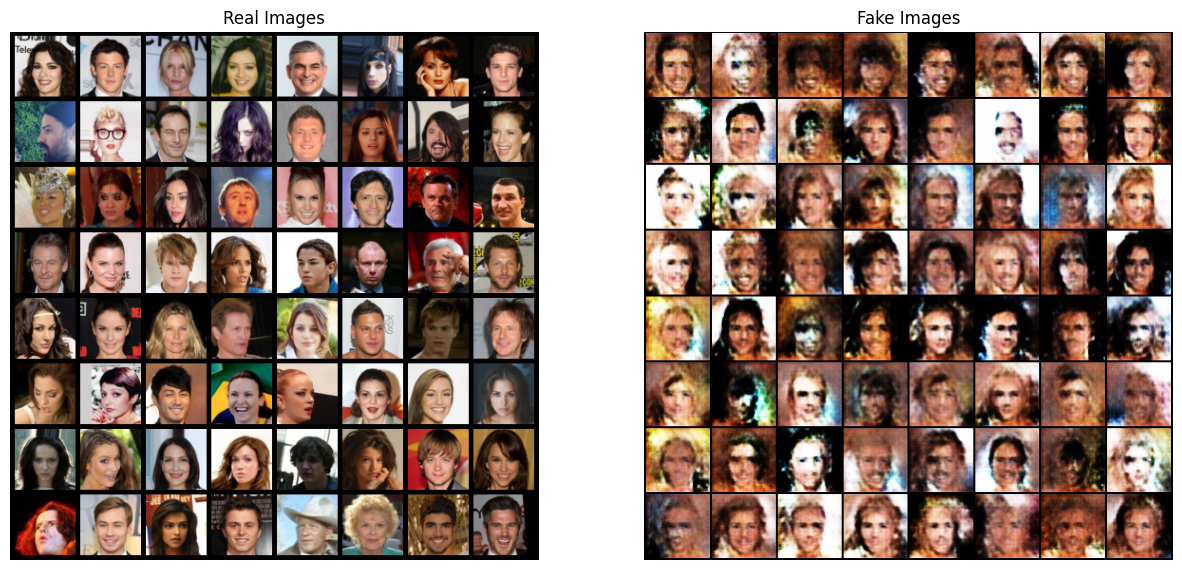

In [14]:
# dataloader에서 진짜 데이터들을 가져옵니다
real_batch = next(iter(dataloader))

# 진짜 이미지들을 화면에 출력합니다
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# 가짜 이미지들을 화면에 출력합니다
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()